In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib import Policy

import IPython.core.display_functions

from src.parsers import HMParser, CotevParser
from src.resources import Aggregator, Generator, Load, Storage
from src.algorithms.rl import EnergyCommunitySequentialV0

import warnings
warnings.filterwarnings('ignore')

2024-05-21 15:43:41,951	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

# EC data for non-renewable generators and batteries
data_ec = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data_ec.parse()

# EV data from the EV4EU simulator
data_ev = CotevParser(population_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/population_731.csv',
                      driving_history_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/ev_driving_history_731.csv',
                      assigned_segments_path='/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/assigned_segments_731.csv',
                      parse_date_start='2019',
                      parse_date_end='2020')
data_ev.parse()

In [3]:
# UPAC Data load

data_upacs = {}
for i in glob.glob('/Users/ecgomes/Documents/PhD/UPAC data/upac*_pv.csv'):
    temp = pd.read_csv(i, index_col=0, parse_dates=True)
    temp = temp.resample('H').mean()
    
    # Need to divide by 1000 to convert from W to kW
    temp['pv'] = temp['pv'] / 1000
    temp['load'] = temp['load'] / 1000
    
    # We only want 2019 and 2020 data
    temp = temp.loc['2019':'2020']
    
    # Fill potential NaN values with interpolation
    temp = temp.interpolate()
    
    name = i.split('/')[-1].split('_')[0].split('upac')[1]
    
    data_upacs[name] = temp

In [4]:
# Sanity check for upac and ev dimensions

print('UPAC data:')
for i in data_upacs.keys():
    print('UPAC {}: {}'.format(i, data_upacs[i].shape))
    
print('\nEV data:')
for i in range(len(data_ev.resources)):
    print('EV {}: {}'.format(i, data_ev.resources[i].lower_bound.shape))

UPAC data:
UPAC 08: (17544, 2)
UPAC 06: (17544, 2)
UPAC 02: (17544, 2)
UPAC 09: (17544, 2)
UPAC 13: (17544, 2)

EV data:
EV 0: (17544,)
EV 1: (17544,)
EV 2: (17544,)
EV 3: (17544,)
EV 4: (17544,)


In [5]:
# Train resource creation

def create_resources(upacs, ec, ev):
    """
    Create the resources for the training environment.
    return a list of resources.
    :param upacs: dict with the UPAC data
    :param ec: dict with the EC data
    :param ev: dict with the EV data
    """
    
    resources = []
    
    # Add generators (from pv column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Generator(
            name='ren_generator_' + current_name,
            value=np.zeros(upacs[current_name]['pv'].shape),
            lower_bound=np.zeros(upacs[current_name]['pv'].shape),
            upper_bound=upacs[current_name]['pv'].values,
            cost=ec.generator['cost_parameter_b'][0] * np.ones(upacs[current_name].shape[0]),
            cost_nde=ec.generator['cost_nde'][0],
            is_renewable=True))
        
    resources.append(Generator(
        name='generator_14',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    
    resources.append(Generator(
        name='generator_15',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
        
    # Add loads (from load column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Load(
            name='load_' + current_name,
            value=upacs[current_name]['load'],
            lower_bound=np.zeros(upacs[current_name].shape),
            upper_bound=upacs[current_name]['load'].values,
            cost=np.ones(upacs[current_name].shape[0]),
            cost_cut=ec.load['cost_cut'][0],
            cost_reduce=ec.load['cost_reduce'][0],
            cost_ens=ec.load['cost_ens'][0]))
        
    # Add storage (from the EC data)
    for i in range(ec.storage['p_charge_limit'].shape[0]):
        resources.append(Storage(
            name='storage_{:02d}'.format(i+1),
            value=ec.storage['initial_state'][i] * np.ones(upacs['02'].shape[0]),
            lower_bound=np.ones(upacs['02'].shape[0]) * ec.storage['energy_min_percentage'][i],
            upper_bound=(ec.storage['energy_capacity'][i] * np.ones(upacs['02'].shape[0])),
            cost=np.ones(upacs['02'].shape[0]),
            cost_discharge=np.tile(ec.storage['discharge_price'][i], (int(upacs['02'].shape[0] / 24))),
            cost_charge=np.tile(ec.storage['charge_price'][i], (int(upacs['02'].shape[0] / 24))),
            capacity_max=ec.storage['energy_capacity'][i],
            capacity_min=ec.storage['energy_min_percentage'][i],
            initial_charge=ec.storage['initial_state'][i],
            discharge_efficiency=ec.storage['discharge_efficiency'][i],
            discharge_max=np.tile(ec.storage['p_discharge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            charge_efficiency=ec.storage['charge_efficiency'][i],
            charge_max=np.tile(ec.storage['p_charge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            capital_cost=np.array([0.05250, 0.10500, 0.01575])))
        
    # Add vehicles (from the EV data)
    for i in np.arange(len(ev)):
        # Append to the list of resources
        resources.append(ev[i])
    
    # Append Aggregator
    resources.append(Aggregator(
        name='aggregator',
        value=np.zeros(upacs['02'].shape[0]),
        lower_bound=np.zeros(upacs['02'].shape[0]),
        upper_bound=np.tile(ec.peers['import_contracted_p_max'][0, 0], (upacs['02'].shape[0])),
        cost=np.tile(ec.peers['buy_price'][0, 0], (upacs['02'].shape[0])),
        imports=np.zeros(upacs['02'].shape[0]),
        exports=np.zeros(upacs['02'].shape[0]),
        import_cost=np.tile(ec.peers['buy_price'][0, 0], (int(upacs['02'].shape[0]))), # * 100,
        export_cost=np.tile(ec.peers['sell_price'][0, 0], (int(upacs['02'].shape[0]))),
        import_max=np.tile(ec.peers['import_contracted_p_max'][0, 0], (int(upacs['02'].shape[0]))),
        export_max=np.tile(ec.peers['export_contracted_p_max'][0, 0], (int(upacs['02'].shape[0])))))
    
    return resources

In [6]:
# Create resources for the training environment

def iterate_resources(u, c, e):
    
    temp = {}
    
    # Save first key of upac data
    first_key = list(u.keys())[0]
    
    # Loop to iterate over days in the datasets
    for i in np.unique(u[first_key].index.date):
        # Create the resources for the training environment
        
        date = i.strftime('%Y-%m-%d')
        
        temp_u = {k: v.loc[date] for k, v in u.items()}
        temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)
        
        temp[date] = create_resources(upacs=temp_u,
                                      ec=c,
                                      ev=temp_e)
        
    return temp

dataset_resources = iterate_resources(u=data_upacs, c=data_ec, e=data_ev)

In [7]:
# Create the execution order

execution_order = [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][:5]] + \
                  [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][12:15]] + \
                  [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][15:-1]] + \
                  [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][5:7]]
execution_order

['ren_generator_08',
 'ren_generator_06',
 'ren_generator_02',
 'ren_generator_09',
 'ren_generator_13',
 'storage_01',
 'storage_02',
 'storage_03',
 'ev_01',
 'ev_02',
 'ev_03',
 'ev_04',
 'ev_05',
 'generator_14',
 'generator_15']

In [8]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunitySequentialV0(ren_generators=dataset_resources[list(dataset_resources.keys())[0]][:5],
                                       generators=dataset_resources[list(dataset_resources.keys())[0]][5:7],
                                       loads=dataset_resources[list(dataset_resources.keys())[0]][7:12],
                                       storages=dataset_resources[list(dataset_resources.keys())[0]][12:15],
                                       evs=dataset_resources[list(dataset_resources.keys())[0]][15:-1],
                                       aggregator=dataset_resources[list(dataset_resources.keys())[0]][-1],
                                       ev_penalty=1,
                                       balance_penalty=1,
                                       execution_order=execution_order)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:

    actions = temp_env.action_space_sample()
    next_obs, rewards, terminations, truncations, infos = temp_env.step(actions)

print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [9]:
# Create the policies dictionary

def assign_group_policies(env):

    policies = {'generator_renewable': (None,
                              env.observation_space['ren_generator_08'],
                              env.action_space['ren_generator_08'],
                              {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                'generator_non_renewable': (None,
                              env.observation_space['generator_14'],
                              env.action_space['generator_14'],
                              {}),
                }

    return policies

policies = assign_group_policies(env=temp_env)

In [ ]:
import logging
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env
from ray.train import Checkpoint

ray.shutdown()
ray.init()

IMPORT_PENALTY = 1 #100
EXPORT_PENALTY = 1 #10
STORAGE_ACTION_PENALTY = 1 #1000
STORAGE_ACTION_REWARD = 5 #10
EV_ACTION_PENALTY = 1 #1000
EV_ACTION_REWARD = 5 #10
EV_REQUIREMENT_PENALTY = 2 #3000
BALANCE_PENALTY = 200 #20000

checkpoint = None
checkpoint_path = None
algo = None

# Build a loop for using separate resources on a daily basis
for datapoint in list(dataset_resources.keys())[:1]:
    
    temp_resources = dataset_resources[datapoint]

    register_env("EC_Multi", lambda config: EnergyCommunitySequentialV0(ren_generators=temp_resources[:5],
                                                                        generators=temp_resources[5:7],
                                                                        loads=temp_resources[7:12],
                                                                        storages=temp_resources[12:15],
                                                                        evs=temp_resources[15:-1],
                                                                        aggregator=temp_resources[-1],
                                                                        ev_penalty=1,
                                                                        balance_penalty=BALANCE_PENALTY,
                                                                        execution_order=execution_order)
                 )

    # Define the PPOConfig
    config = PPOConfig()\
        .environment(env="EC_Multi", disable_env_checking=False)\
        .training(train_batch_size=240,
                  lr=2e-4, #tune.grid_search([0.001, 0.0001]),
                  gamma=0.99,
                  use_gae=True,
                  use_critic=True)\
        .framework('torch') \
        .rollouts(batch_mode='complete_episodes',
                  num_rollout_workers=1,
                  rollout_fragment_length='auto')\
        .multi_agent(policies=policies,
                     policy_mapping_fn=(lambda agent_id, episode, worker, **kwargs:
                                        'generator_renewable' if (agent_id.startswith('ren_gen')) else
                                        'storage' if agent_id.startswith('storage') else
                                        'ev' if agent_id.startswith('ev') else
                                        'generator_non_renewable'))

    #results = tune.run(
    #    "PPO",
    #    stop={"training_iteration": 100},
    #    config=config.to_dict(),
    #    checkpoint_at_end=True,
    #    verbose=0,
    #)
    algo = config.build()
    
    # Load the checkpoint if it exists
    if checkpoint is not None:
        policy = Policy.from_checkpoint(checkpoint.checkpoint.path)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    elif checkpoint_path is not None:
        checkpoint = Checkpoint.from_directory(checkpoint_path)
        policy = Policy.from_checkpoint(checkpoint)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    
    # Clear the Jupyter cell output
    IPython.core.display_functions.clear_output()
    
    # Train for n iterations and report results (mean episode rewards)
    print(f"Day {datapoint}\n")
    for i in range(100):
        results = algo.train()
        print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
        #if results['episode_reward_mean'] > 500:
        #    break
    
    # Save the checkpoint to disk.
    checkpoint = algo.save()
    #print("checkpoints saved at", checkpoint)

In [11]:
# Check the results
# Create a new env

test_resources = dataset_resources[list(dataset_resources.keys())[0]]

test_env = EnergyCommunitySequentialV0(ren_generators=test_resources[:5],
                                       generators=test_resources[5:7],
                                       loads=test_resources[7:12],
                                       storages=test_resources[12:15],
                                       evs=test_resources[15:-1],
                                       aggregator=test_resources[-1],
                                       ev_penalty=1,
                                       balance_penalty=BALANCE_PENALTY,
                                       execution_order=execution_order)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

while not terminations['__all__'] and not truncations['__all__']:

    current_agent = test_env.execution_order[test_env._current_agent_idx]

    current_policy = 'generator_renewable' if current_agent.startswith('ren_gen') else \
        'storage' if current_agent.startswith('storage') else \
            'ev' if current_agent.startswith('ev') else \
                'generator_non_renewable'

    action_dict = {current_agent: algo.compute_single_action(observation=obs[current_agent],
                                                             policy_id=current_policy)}

    obs, rewards, terminations, truncations, info = test_env.step(action_dict)

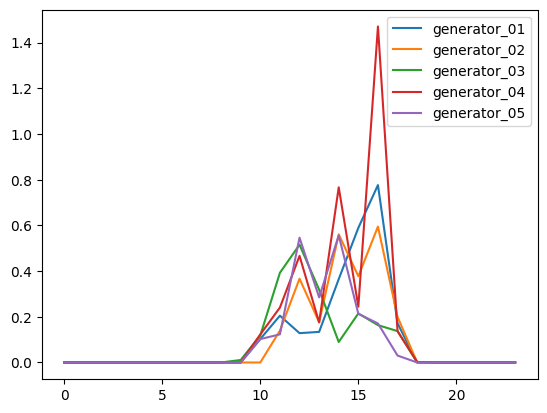

In [12]:
# Plot the generator power output

plt.figure()

for i in range(5):
    plt.plot(test_env.ren_generators[i].value)

plt.legend(['generator_{:02d}'.format(i+1) for i in range(data_ec.generator['p_forecast'].shape[0])])
plt.show()

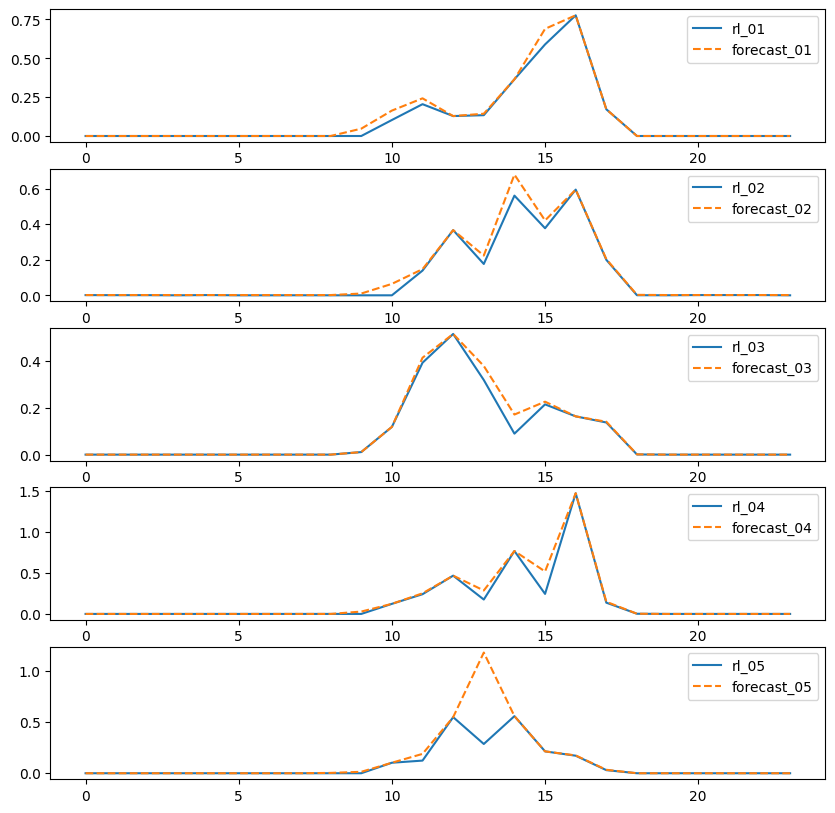

In [13]:
# Create subplots with the generator values and the forecast

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in np.arange(5):
    axs[i].plot(test_env.ren_generators[i].value, label='rl_{:02d}'.format(i+1))
    axs[i].plot(data_upacs[list(data_upacs.keys())[i]]['pv'].loc['2019-01-01'].values, label='forecast_{:02d}'.format(i+1),
                linestyle='--')
    
    axs[i].legend()
    
plt.show()

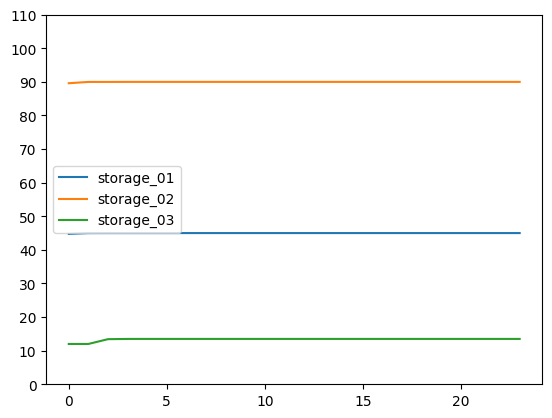

In [14]:
# Plot the storage state of charge

plt.figure()

for i in range(data_ec.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.yticks(np.arange(0, 120, 10))

plt.legend(['storage_{:02d}'.format(i+1) for i in range(data_ec.storage['p_charge_limit'].shape[0])])
plt.show()

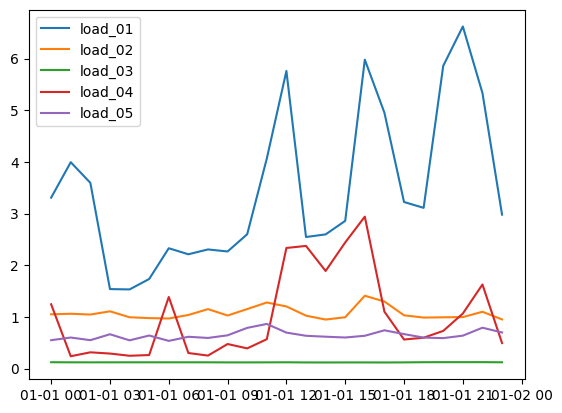

In [15]:
# Plot the load values

plt.figure()

for i in range(5):
    plt.plot(test_env.loads[i].value)
    
plt.legend(['load_{:02d}'.format(i+1) for i in range(5)])
plt.show()

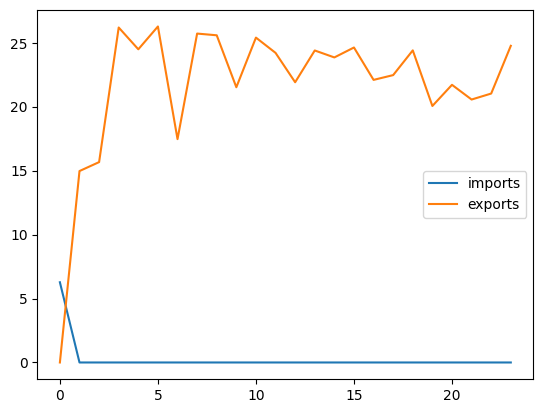

In [16]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

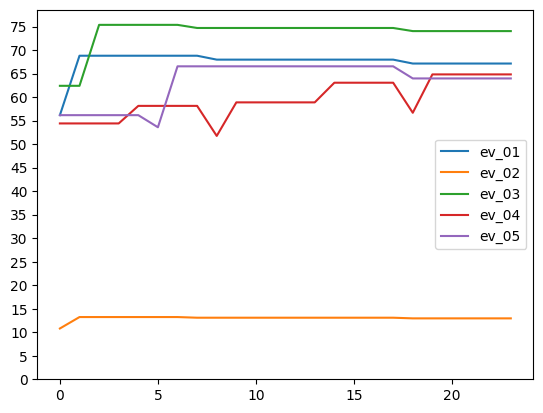

In [17]:
# Check EVs

plt.figure()

for ev in test_env.evs:
    plt.plot(ev.value * ev.capacity_max, label=ev.name)

plt.yticks(np.arange(0, 80, 5))
plt.legend()

plt.show()

In [18]:
for ev in test_env.evs:
    print(ev.name)
    print(ev.charge)

ev_01
[0.    6.318 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
ev_02
[0.    1.215 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
ev_03
[0.   0.   6.48 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
ev_04
[0.         0.         0.         0.         1.8665547  0.
 0.         0.         0.         3.56689068 0.         0.
 0.         0.         2.0891783  0.         0.         0.
 0.         4.07803736 0.         0.         0.         0.        ]
ev_05
[0.   0.   0.   0.   0.   0.   6.48 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


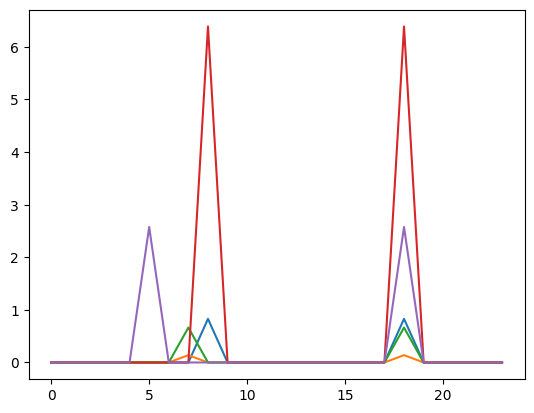

In [19]:
for i in range(len(test_env.evs)):
    plt.plot(test_env.evs[i].schedule_requirement_soc)

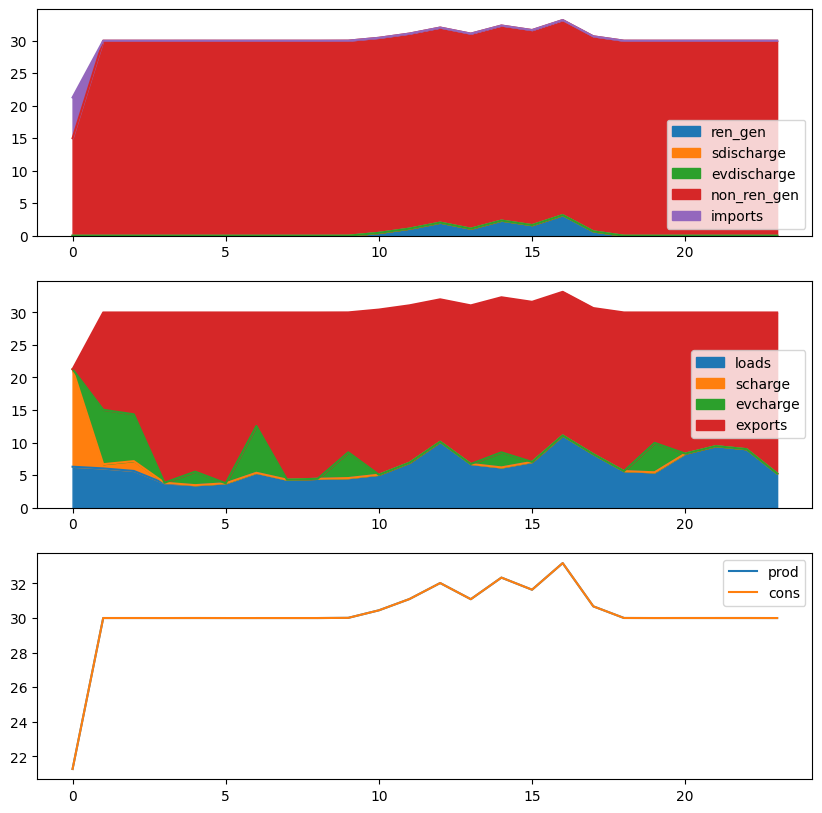

In [20]:
# Check the sum of values

test_prod = pd.DataFrame({'ren_gen': np.sum([test_env.ren_generators[i].value for i in range(5)], axis=0),
                          'sdischarge': np.sum([test_env.storages[i].discharge for i in range(3)], axis=0),
                          'evdischarge': np.sum([test_env.evs[i].discharge for i in range(5)], axis=0),
                          'non_ren_gen': np.sum([test_env.generators[i].value for i in range(2)], axis=0),
                          'imports': test_env.aggregator.imports})

test_cons = pd.DataFrame({'loads': np.sum([test_env.loads[i].value for i in range(5)], axis=0),
                          'scharge': np.sum([test_env.storages[i].charge / test_env.storages[i].charge_efficiency 
                                             for i in range(3)], axis=0),
                          'evcharge': np.sum([test_env.evs[i].charge / test_env.evs[i].charge_efficiency 
                                              for i in range(5)], axis=0),
                          'exports': test_env.aggregator.exports})

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

test_prod.plot(kind='area', ax=axs[0])
test_cons.plot(kind='area', ax=axs[1])

axs[2].plot(test_prod.sum(axis=1)[0:], label='prod')
axs[2].plot(test_cons.sum(axis=1)[0:], label='cons')

plt.legend()
plt.show()

In [23]:
test_prod

,ren_gen,sdischarge,evdischarge,non_ren_gen,imports
0,0.000158,0.0,0.0,0.0,2.888731
1,0.001392,0.0,0.0,0.0,6.013197
2,0.001374,0.0,0.0,0.0,5.621742
3,0.001527,0.0,0.0,0.0,8.589094
4,0.001438,0.0,0.0,0.0,9.318465
5,0.001410,0.0,0.0,0.0,5.079485
6,0.001417,0.0,0.0,0.0,5.337770
7,0.001219,0.0,0.0,0.0,7.050895
8,0.004899,0.0,0.0,0.0,4.415120
9,0.110892,0.0,0.0,0.0,11.558102


In [24]:
test_cons

,loads,scharge,evcharge,exports
0,6.272973,0.000000e+00,2.888888,0.0
1,6.014588,9.113559e+00,0.000000,0.0
2,5.623117,6.950230e+00,0.000000,0.0
3,3.720585,1.147012e+00,4.870036,0.0
4,3.437838,4.604298e-02,5.882065,0.0
5,3.730895,1.849844e-03,1.350000,0.0
6,5.339187,2.031250e-06,0.000000,0.0
7,4.285127,7.247032e-05,2.766987,0.0
8,4.420018,2.899829e-06,0.000000,0.0
9,4.530002,1.160439e-07,7.138992,0.0


In [23]:
test_env.aggregator.imports

array([10.75382632, 12.81458833,  5.62311667,  3.720585  , 12.44869119,
        5.080895  ,  5.65875177,  4.28512667,  4.42001833,  4.53000167,
        5.04745667,  6.89479833, 10.114815  ,  6.696835  ,  6.16782333,
        7.01326   , 11.08323333,  8.20876167,  5.60267833,  5.41581   ,
        8.29380167,  9.44345333,  8.97574   ,  5.24343333])